In [1]:
# import holoviews as hv
import os

import numpy as np
import pandas as pd
import pyxel
import xarray as xr
from matplotlib import pyplot as plt

# from tkinter import Tcl

In [2]:
from pyxel.calibration.fitness import reduced_chi_squared

## Functions

In [3]:
def get_fileList_txt(directorypath):
    fileList = []
    count = 0

    for dirname, dirnames, filenames in os.walk(directorypath):
        for filename in filenames:
            if filename.endswith(".txt"):
                fileList.append(f"{dirname}/{filename}")
                count = count + 1
    return Tcl().call("lsort", "-dict", fileList)  #        masked_details

In [4]:
def open_data_in_order(correct_order_list):
    dataset_lst = []
    for i in range(len(correct_order_list)):
        tmp = xr.open_dataset(f"{correct_order_list[i]}")
        # tmp = xr.open_dataset(f"/home/brad-tmp/project-pyxel/Euclid/notebooks/calibration_output/correct_runs/original_filenames/{correct_order_list[i]}/dataset.nc")   # 1 trap
        dataset_lst.append(tmp)
    return dataset_lst

In [5]:
def get_txt_files(filename_lst):
    charge_profile_lst = []
    for i in range(len(filename_lst)):
        tmp = open_file(filename_lst[i])
        charge_profile_lst.append(tmp)
    return charge_profile_lst

In [6]:
def open_file(filename):
    df = pd.read_csv(filename, delimiter="\t", header=None)
    return df

In [7]:
def get_fileList_dataset(directorypath):
    fileList = []
    count = 0

    for dirname, dirnames, filenames in os.walk(directorypath):
        for filename in filenames:
            if filename.endswith(".nc"):
                fileList.append(f"{dirname}/{filename}")
                count = count + 1
    return Tcl().call("lsort", "-dict", fileList)  #        masked_details

In [8]:
def find_best(ds):
    best = (
        ds.champion_parameters.isel(evolution=-1)
        .isel(island=ds.champion_fitness.isel(evolution=-1).argmin())
        .to_dataframe()
    )
    return best, best["island"][0], best["evolution"][0]

In [9]:
# @numba.njit


def reduced_chi_squared_old(
    simulated: np.ndarray,
    target: np.ndarray,
    weighting: np.ndarray,
    free_parameters: int,
) -> float:
    diff = target - simulated
    deviation2 = np.square(diff / weighting)

    size = np.isfinite(diff).sum()

    degrees_of_freedom = size - free_parameters
    reduced_chi2 = float(np.nansum(deviation2)) / degrees_of_freedom

    return reduced_chi2

In [10]:
def find_best_of_data_list(data_list):
    best_data = []
    for i in range(len(data_list)):
        best_data_tmp = find_best(data_list[i])
        best_data.append(best_data_tmp)
    return best_data

In [11]:
def get_filenames_from_fileList(fileList):
    filename_list = []
    for files in fileList:
        filename_list.append(files.split("/")[-1].split(".")[0])

    return filename_list

In [12]:
def find_best_parameters_3_trap_species_slow_trap(
    best_data, filenames, wnd_input=None, beta_input=None, fef_input=None
):
    density_vals = []
    rt_vals = []
    capture_time = []
    wnd_vals = []
    beta_vals = []
    best_island_batch_1 = []
    fef_values = []
    for i in range(len(best_data)):
        density_vals.append(
            [
                best_data[i][0]["champion_parameters"][0],
                best_data[i][0]["champion_parameters"][1],
                best_data[i][0]["champion_parameters"][2],
            ]
        )

        rt_vals.append(
            [
                best_data[i][0]["champion_parameters"][3],
                best_data[i][0]["champion_parameters"][4],
                best_data[i][0]["champion_parameters"][5],
            ]
        )

        capture_time.append(
            [
                best_data[i][0]["champion_parameters"][6],
                best_data[i][0]["champion_parameters"][7],
                best_data[i][0]["champion_parameters"][8],
            ]
        )

        if wnd_input[i] != None:
            wnd = wnd_input[i]
        else:
            wnd = filenames[i].split("_")[4]
        if beta_input[i] != None:
            beta = beta_input[i]
        else:
            beta = filenames[i].split("_")[2]
        if fef_input[i] != None:
            fef = fef_input[i]
        else:
            fef = filenames[i].split("_")[7]

        # wnd = filenames[i].split('_')[4]
        # fef = filenames[i].split('_')[7]
        best_island_batch_1.append(best_data[i][1])

        beta_vals.append(best_data[i][0]["champion_parameters"][10])
        wnd_vals.append(best_data[i][0]["champion_parameters"][9])

        if fef == "closed":
            fef_values.append(0)

        elif fef == "open":
            fef_values.append(best_data[i][0]["champion_parameters"][11])

    return (
        density_vals,
        rt_vals,
        wnd_vals,
        beta_vals,
        fef_values,
        best_island_batch_1,
        capture_time,
    )

In [13]:
def find_best_parameters_3_trap_species(
    best_data, filenames, wnd_input=None, beta_input=None, fef_input=None
):
    density_vals = []
    rt_vals = []
    wnd_vals = []
    beta_vals = []
    best_island_batch_1 = []
    fef_values = []
    for i in range(len(best_data)):
        density_vals.append(
            [
                best_data[i][0]["champion_parameters"][0],
                best_data[i][0]["champion_parameters"][1],
                best_data[i][0]["champion_parameters"][2],
            ]
        )

        rt_vals.append(
            [
                best_data[i][0]["champion_parameters"][3],
                best_data[i][0]["champion_parameters"][4],
                best_data[i][0]["champion_parameters"][5],
            ]
        )

        if wnd_input != None:
            wnd = wnd_input
        else:
            wnd = filenames[i].split("_")[4]
        if beta_input != None:
            beta = beta_input
        else:
            beta = filenames[i].split("_")[2]
        if fef_input != None:
            fef = fef_input
        else:
            fef = filenames[i].split("_")[7]

        # wnd = filenames[i].split('_')[4]
        # fef = filenames[i].split('_')[7]
        best_island_batch_1.append(best_data[i][1])

        if fef == "closed":
            fef_values.append(0)
            if beta == "closed" and wnd == "closed":
                beta_vals.append(0.36)
                wnd_vals.append(0)
            elif beta == "open" and wnd == "closed":
                beta_vals.append(best_data[i][0]["champion_parameters"][6])
                wnd_vals.append(0)
            elif beta == "closed" and wnd == "open":
                beta_vals.append(0.36)
                wnd_vals.append(best_data[i][0]["champion_parameters"][6])
            elif beta == "open" and wnd == "open":
                beta_vals.append(best_data[i][0]["champion_parameters"][7])
                wnd_vals.append(best_data[i][0]["champion_parameters"][6])

        else:
            if beta == "closed" and wnd == "closed":
                beta_vals.append(0.36)
                wnd_vals.append(0)
                fef_values.append(best_data[i][0]["champion_parameters"][6])
            elif beta == "open" and wnd == "closed":
                beta_vals.append(best_data[i][0]["champion_parameters"][6])
                wnd_vals.append(0)
                fef_values.append(best_data[i][0]["champion_parameters"][7])

            elif beta == "closed" and wnd == "open":
                beta_vals.append(0.36)
                wnd_vals.append(best_data[i][0]["champion_parameters"][6])
                fef_values.append(best_data[i][0]["champion_parameters"][7])

            elif beta == "open" and wnd == "open":
                beta_vals.append(best_data[i][0]["champion_parameters"][7])
                wnd_vals.append(best_data[i][0]["champion_parameters"][6])
                fef_values.append(best_data[i][0]["champion_parameters"][8])

    return density_vals, rt_vals, wnd_vals, beta_vals, fef_values, best_island_batch_1

In [14]:
def find_best_parameters_2_4_5_trap_species(best_data, filenames, trap_species):
    density_vals = []
    rt_vals = []
    wnd_vals = []
    beta_vals = []
    best_island_batch_1 = []
    fef_values = []
    if trap_species == 2:
        print("2 traps!")
        for i in range(len(best_data)):
            density_vals.append(
                [
                    best_data[i][0]["champion_parameters"][0],
                    best_data[i][0]["champion_parameters"][1],
                ]
            )

            rt_vals.append(
                [
                    best_data[i][0]["champion_parameters"][2],
                    best_data[i][0]["champion_parameters"][3],
                ]
            )

            best_island_batch_1.append(best_data[i][1])

            wnd_vals.append(best_data[i][0]["champion_parameters"][4])
            beta_vals.append(best_data[i][0]["champion_parameters"][5])
            fef_values.append(best_data[i][0]["champion_parameters"][6])

    elif trap_species == 4:
        print("4 traps!")
        for i in range(len(best_data)):
            density_vals.append(
                [
                    best_data[i][0]["champion_parameters"][0],
                    best_data[i][0]["champion_parameters"][1],
                    best_data[i][0]["champion_parameters"][2],
                    best_data[i][0]["champion_parameters"][3],
                ]
            )

            rt_vals.append(
                [
                    best_data[i][0]["champion_parameters"][4],
                    best_data[i][0]["champion_parameters"][5],
                    best_data[i][0]["champion_parameters"][6],
                    best_data[i][0]["champion_parameters"][7],
                ]
            )

            best_island_batch_1.append(best_data[i][1])

            wnd_vals.append(best_data[i][0]["champion_parameters"][8])
            beta_vals.append(best_data[i][0]["champion_parameters"][9])
            fef_values.append(best_data[i][0]["champion_parameters"][10])

    elif trap_species == 5:
        print("5 traps!")

        for i in range(len(best_data)):
            density_vals.append(
                [
                    best_data[i][0]["champion_parameters"][0],
                    best_data[i][0]["champion_parameters"][1],
                    best_data[i][0]["champion_parameters"][2],
                    best_data[i][0]["champion_parameters"][3],
                    best_data[i][0]["champion_parameters"][4],
                ]
            )

            rt_vals.append(
                [
                    best_data[i][0]["champion_parameters"][5],
                    best_data[i][0]["champion_parameters"][6],
                    best_data[i][0]["champion_parameters"][7],
                    best_data[i][0]["champion_parameters"][8],
                    best_data[i][0]["champion_parameters"][9],
                ]
            )

            best_island_batch_1.append(best_data[i][1])

            wnd_vals.append(best_data[i][0]["champion_parameters"][10])
            beta_vals.append(best_data[i][0]["champion_parameters"][11])
            fef_values.append(best_data[i][0]["champion_parameters"][12])

    return density_vals, rt_vals, wnd_vals, beta_vals, fef_values, best_island_batch_1

In [15]:
def get_avg_peak_signl(lst):
    signal_lst = []
    for i in range(len(lst)):
        tmp = np.average(lst[i][1500:2050])
        signal_lst.append(tmp)
    return signal_lst

In [66]:
def create_flat_profiles_10(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(11):
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065 : 2065 + 10])
        target_profile_0d.append(tmp1[2065 : 2065 + 10])
        root_weighting_profiles_0d.append(tmp2[2065 : 2065 + 10])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [67]:
def create_flat_profiles_25(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(11):
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065 : 2065 + 25])
        target_profile_0d.append(tmp1[2065 : 2065 + 25])
        root_weighting_profiles_0d.append(tmp2[2065 : 2065 + 25])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [68]:
def create_flat_profiles_50(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(11):
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065 : 2065 + 50])
        target_profile_0d.append(tmp1[2065 : 2065 + 50])
        root_weighting_profiles_0d.append(tmp2[2065 : 2065 + 50])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [69]:
def create_flat_profiles_100(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(11):
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065 : 2065 + 100])
        target_profile_0d.append(tmp1[2065 : 2065 + 100])
        root_weighting_profiles_0d.append(tmp2[2065 : 2065 + 100])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [345]:
def create_flat_profiles_full(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(8):  # 11 for batches, 8 for set 11
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065:])
        target_profile_0d.append(tmp1[2065:])
        root_weighting_profiles_0d.append(tmp2[2065:])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [71]:
def create_flat_profiles(
    result_list, target_profiles, root_weighting_profiles, EPER_length
):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(11):
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065 : 2065 + EPER_length])
        target_profile_0d.append(tmp1[2065 : 2065 + EPER_length])
        root_weighting_profiles_0d.append(tmp2[2065 : 2065 + EPER_length])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [72]:
def reduced_chi2_with_flat_profiles(
    result_profile, target_profile_0d, root_weighting_profiles_0d, free_parameters=12
):
    reduced_chi2_test_list = []
    for i in range(11):
        diff_test = target_profile_0d[i] - result_profile[i]
        deviation2_test = np.square(diff_test / root_weighting_profiles_0d[i])

        size = diff_test.size

        degrees_of_freedom = size - free_parameters
        reduced_chi2_test = float(np.sum(deviation2_test)) / degrees_of_freedom
        reduced_chi2_test_list.append(reduced_chi2_test)
    return reduced_chi2_test_list

## Get profiles

In [16]:
input_dirname = "../../data/1D/input"
input_fileList = get_fileList_txt(input_dirname)
target_dirname = "../../data/1D/target"
target_fileList_tmp = get_fileList_txt(target_dirname)
target_fileList = target_fileList_tmp

In [17]:
filtered_input_filList = []
for i in range(len(input_fileList)):
    if (
        input_fileList[i]
        == "../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_0.txt"
    ):
        pass
    elif (
        input_fileList[i]
        == "../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_40.txt"
    ):
        pass
    else:
        filtered_input_filList.append(input_fileList[i])

In [19]:
filtered_target_fileList = []
for i in range(len(target_fileList)):
    if (
        target_fileList[i]
        == "../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/target/G/r_G1_0.txt"
    ):
        pass
    elif (
        target_fileList[i]
        == "../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/target/G/r_G1_40.txt"
    ):
        pass
    else:
        filtered_target_fileList.append(target_fileList[i])

In [21]:
input_profiles = get_txt_files(filtered_input_filList)
target_profiles = get_txt_files(filtered_target_fileList)

In [26]:
exposure_weighting_fileList = get_fileList_txt("../../data/1D/target")
exposure_weighting_fileList

('../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_0.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_10.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_20.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_30.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_40.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_50.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_60.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_70.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_80.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_90.txt',
 '../../../profiles_and_fits/pr

In [27]:
filtered_weighting_fileList = []
for i in range(len(exposure_weighting_fileList)):
    if (
        exposure_weighting_fileList[i]
        == "../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_0.txt"
    ):
        pass
    elif (
        exposure_weighting_fileList[i]
        == "../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_40.txt"
    ):
        pass
    else:
        filtered_weighting_fileList.append(exposure_weighting_fileList[i])

In [28]:
filtered_weighting_fileList

['../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_10.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_20.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_30.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_50.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_60.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_70.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_80.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_90.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_100.txt',
 '../../../profiles_and_fits/profiles/27_11_2023_F1_G1_profiles/std_dev/G/root_100/r_G1_110.txt',
 '../../../profiles_and_fits

In [29]:
root_weighting_profiles = get_txt_files(filtered_weighting_fileList)

# Reduced chi squared calc

### Opening dataset and extracting parameters

Using data from set_9_calibrations - simulation 4 - reduced chi squared fitness func using std dev profiles for weighitng

In [ ]:
fileList = get_fileList_dataset("../Results/")
fileList

In [ ]:
filenames = get_filenames_from_fileList(fileList)

In [ ]:
all_data_in_correct_order = open_data_in_order(fileList_batch)

In [ ]:
best_data = find_best(all_data_in_correct_order)

In [ ]:
(
    density_vals_batch,
    rt_vals_batch,
    wnd_vals_batch,
    beta_vals_batch,
    fef_values_batch,
    best_island_batch,
) = find_best_parameters_3_trap_species(
    best_data, filenames, wnd_input="closed", beta_input="closed", fef_input="closed"
)

In [48]:
id_1_profiles = create_flat_profiles(
    id_1_sim_results_5, target_profiles, root_weighting_profiles, 235
)
id1_reduced_chi2 = reduced_chi2_with_flat_profiles(
    id_1_profiles[0], id_1_profiles[1], id_1_profiles[2]
)

NameError: name 'id_1_sim_results_5' is not defined

## running sims

In [36]:
filtered_input_filList

['../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_10.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_20.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_30.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_50.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_60.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_70.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_80.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_90.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_100.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_110.txt',
 '../../../profiles_and_fits/profiles/input/G0/a

In [99]:
filtered_input_filList

['../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_10.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_20.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_30.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_50.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_60.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_70.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_80.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_90.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_100.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_110.txt',
 '../../../profiles_and_fits/profiles/input/G0/a

In [48]:
config = pyxel.load("unit_tests_for_calibrations_using_exposure_slow_trap.yaml")
detector = config.detector
pipeline = config.pipeline
exposure = config.exposure

In [ ]:
pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_capture_timescales

In [98]:
input_fileList

('../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_0.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_10.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_20.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_30.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_40.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_50.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_60.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_70.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_80.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_90.txt',
 '../../../profiles_and_fits/profiles/input/G0/abs_

In [122]:
def run_exposure_mode_for_reduced_chi2(
    density_vals,
    input_fileList,
    rt_vals,
    wnd_vals,
    beta_vals,
    fef_vals,
    capture_times=None,
):
    final_result_list = []
    for i in range(len(density_vals)):
        result_list = []
        print("-----------------------------------")
        print("-----------------------------------")
        print(f"   ------------ {i} -------------")
        print("-----------------------------------")
        print("-----------------------------------")
        print(len(input_fileList))
        for input_file in input_fileList:
            config = pyxel.load("unit_tests_for_calibrations_using_exposure.yaml")
            # config = pyxel.load("unit_tests_for_calibrations_using_exposure_slow_trap.yaml")
            # YAML-files/with_noise/arctic_calibration_3trp-red-chi-sqr.yaml")
            detector = config.detector
            pipeline = config.pipeline
            exposure = config.exposure

            if capture_times != None:
                config.pipeline.charge_generation.load_charge.arguments.filename = (
                    input_file
                )
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_densities = density_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_release_timescales = rt_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.well_notch_depth = wnd_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.well_fill_power = beta_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.first_electron_fill = fef_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_capture_timescales = capture_times[
                    i
                ]

                print(
                    config.pipeline.charge_generation.load_charge.arguments.filename
                )  # = input_file
                print(
                    "trap densities",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_densities,
                )  # = density_vals[i]
                print(
                    "trap rt",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_release_timescales,
                )  # = rt_vals[i]
                print(
                    "well notch depth",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.well_notch_depth,
                )  # = wnd_vals[i]
                print(
                    "well fill power",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.well_fill_power,
                )  # = beta_vals[i]
                print(
                    "first electron fill",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.first_electron_fill,
                )  # = fef_vals[i]
                print(
                    "Capture times",
                    config.pipeline.charge_transfer.arctic_add_trap_slow_capture.arguments.trap_capture_timescales,
                )
                print(" - - - - - - - - ")
                print(" ")
                print(" - - - - - - - - ")
                result = pyxel.run_mode(
                    mode=exposure, pipeline=pipeline, detector=detector
                )
                result_list.append(result)

            else:
                config.pipeline.charge_generation.load_charge.arguments.filename = (
                    input_file
                )
                config.pipeline.charge_transfer.arctic_add.arguments.trap_densities = (
                    density_vals[i]
                )
                config.pipeline.charge_transfer.arctic_add.arguments.trap_release_timescales = rt_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add.arguments.well_notch_depth = wnd_vals[
                    i
                ]
                config.pipeline.charge_transfer.arctic_add.arguments.well_fill_power = (
                    beta_vals[i]
                )
                config.pipeline.charge_transfer.arctic_add.arguments.first_electron_fill = fef_vals[
                    i
                ]
                # config.pipeline.charge_transfer.arctic_add.arguments.trap_capture_timescales = capture_times[i]

                print(
                    config.pipeline.charge_generation.load_charge.arguments.filename
                )  # = input_file
                print(
                    "trap densities",
                    config.pipeline.charge_transfer.arctic_add.arguments.trap_densities,
                )  # = density_vals[i]
                print(
                    "trap rt",
                    config.pipeline.charge_transfer.arctic_add.arguments.trap_release_timescales,
                )  # = rt_vals[i]
                print(
                    "well notch depth",
                    config.pipeline.charge_transfer.arctic_add.arguments.well_notch_depth,
                )  # = wnd_vals[i]
                print(
                    "well fill power",
                    config.pipeline.charge_transfer.arctic_add.arguments.well_fill_power,
                )  # = beta_vals[i]
                print(
                    "first electron fill",
                    config.pipeline.charge_transfer.arctic_add.arguments.first_electron_fill,
                )  # = fef_vals[i]
                # print('Capture times',config.pipeline.charge_transfer.arctic_add_trap.arguments.trap_capture_timescales)
                print(" - - - - - - - - ")
                print(" ")
                print(" - - - - - - - - ")
                result = pyxel.run_mode(
                    mode=exposure, pipeline=pipeline, detector=detector
                )
                result_list.append(result)

        final_result_list.append(result_list)
    # result_list.append(result)
    return final_result_list

In [92]:
%%time
result_list_batch_7 = run_exposure_mode_for_reduced_chi2(
    density_vals_batch_7,
    filtered_input_filList,
    rt_vals_batch_7,
    wnd_vals_batch_7,
    beta_vals_batch_7,
    fef_values_batch_7,
    capture_time_batch_7,
)

-----------------------------------
-----------------------------------
   ------------ 0 -------------
-----------------------------------
-----------------------------------
11
../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_10.txt
trap densities [0.588458600380733, 0.6043372462603916, 0.07512938293978311]
trap rt [228.78428475093108, 0.7455489926256192, 15.611595747431613]
well notch depth 0.3621983544056916
well fill power 0.20550043482807162
first electron fill -0.06377366015112597
Capture times [10.918393264470867, 34.717284890685626, 1.903105835957377]
 - - - - - - - - 
 
 - - - - - - - - 
../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_20.txt
trap densities [0.588458600380733, 0.6043372462603916, 0.07512938293978311]
trap rt [228.78428475093108, 0.7455489926256192, 15.611595747431613]
well notch depth 0.3621983544056916
well fill power 0.20550043482807162
first electron fill -0.06377366015112597
Capture tim

In [90]:
result_list_set_11_3_trp = run_exposure_mode_for_reduced_chi2(
    density_vals_set_11,
    input_list_50_plus,
    rt_vals_set_11,
    wnd_vals_set_11,
    beta_vals_set_11,
    fef_values_set_11,
)

-----------------------------------
-----------------------------------
   ------------ 0 -------------
-----------------------------------
-----------------------------------
8
../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_50.txt
trap densities [0.13206381132097308, 1.706165655452753, 0.020570758056025654]
trap rt [10.014579105158171, 261.8598740976681, 3.83425712810077e-07]
well notch depth 0.36465785175691307
well fill power 0.36
first electron fill 0
 - - - - - - - - 
 
 - - - - - - - - 
../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_60.txt
trap densities [0.13206381132097308, 1.706165655452753, 0.020570758056025654]
trap rt [10.014579105158171, 261.8598740976681, 3.83425712810077e-07]
well notch depth 0.36465785175691307
well fill power 0.36
first electron fill 0
 - - - - - - - - 
 
 - - - - - - - - 
../../../profiles_and_fits/profiles/input/G0/abs_processing/altered_flat_field/r_G0_70.txt
trap densities [0

### Checking result data

In [167]:
final_result_list_11 = result_list_set_11_3_trp[6:12]

In [168]:
filenames_set_11[6:12]

['3Trp_2065_start_2065_trim_1_over_std_Dev_red_ch_sqr',
 '3Trp_2065_start_2065_trim_1_over_std_Dev_sum_sqr_resid',
 '3Trp_2065_start_2065_trim_NORM_1_over_std_Dev_times_1_over_N_red_ch_sqr',
 '3Trp_2065_start_2065_trim_NORM_1_over_std_Dev_times_1_over_N_sum_sqr_resid',
 '3Trp_2065_start_2065_trim_NORM_1_over_std_dev_times_sqrtN_red_ch_sqr',
 '3Trp_2065_start_2065_trim_NORM_1_over_std_dev_times_sqrtN_sum_sqr_resid']

In [ ]:
reduced_chi2_full_EPER = reduced_chi2_with_flat_profiles(
    profiles_list[0][0], profiles_list[0][1], profiles_list[0][2], free_params
)

In [362]:
def create_flat_profiles_full(result_list, target_profiles, root_weighting_profiles):
    target_profile_0d = []
    root_weighting_profiles_0d = []
    result_profile = []
    for i in range(8):  # 11 for batches, 8 for set 11
        tmp1 = target_profiles[i].values.squeeze()
        tmp2 = root_weighting_profiles[i].values.squeeze()
        tmp3 = result_list[i]["pixel"].squeeze().values
        result_profile.append(tmp3[2065:])
        target_profile_0d.append(tmp1)  # [2065:])
        root_weighting_profiles_0d.append(tmp2[2065:])
    return result_profile, target_profile_0d, root_weighting_profiles_0d

In [364]:
def reduced_chi2_with_flat_profiles(
    result_profile, target_profile_0d, root_weighting_profiles_0d, free_parameters=12
):
    reduced_chi2_test_list = []
    for i in range(8):
        diff_test = target_profile_0d[i] - result_profile[i]
        deviation2_test = np.square(diff_test / root_weighting_profiles_0d[i])

        size = diff_test.size

        degrees_of_freedom = size - free_parameters
        reduced_chi2_test = float(np.sum(deviation2_test)) / degrees_of_freedom
        reduced_chi2_test_list.append(reduced_chi2_test)
    return reduced_chi2_test_list

In [125]:
def create_multi_profiles(sim_results, target_profiles, weighting_profiles):
    # profiles_0_10 = create_flat_profiles_10(sim_results,target_profiles,weighting_profiles)
    # profiles_0_25 = create_flat_profiles_25(sim_results,target_profiles,weighting_profiles)
    # profiles_0_50 = create_flat_profiles_50(sim_results,target_profiles,weighting_profiles)
    # profiles_0_100 = create_flat_profiles_100(sim_results,target_profiles,weighting_profiles)
    # profiles_0_200 = create_flat_profiles_200(sim_results,target_profiles,weighting_profiles)
    # profiles_0_300 = create_flat_profiles_300(sim_results,target_profiles,weighting_profiles)
    # profiles_0_400 = create_flat_profiles_400(sim_results,target_profiles,weighting_profiles)
    # profiles_0_500 = create_flat_profiles_500(sim_results,target_profiles,weighting_profiles)
    # profiles_0_600 = create_flat_profiles_600(sim_results,target_profiles,weighting_profiles)
    # profiles_0_700 = create_flat_profiles_700(sim_results,target_profiles,weighting_profiles)
    # profiles_0_800 = create_flat_profiles_800(sim_results,target_profiles,weighting_profiles)
    profiles_0_full = create_flat_profiles_full(
        sim_results, target_profiles, weighting_profiles
    )
    return profiles_0_full
    # return profiles_0_10, profiles_0_25, profiles_0_50, profiles_0_100, profiles_0_200, profiles_0_300, profiles_0_400, profiles_0_500, profiles_0_600, profiles_0_700, profiles_0_800, profiles_0_full

In [338]:
def changing_EPER_tail_reduced_chi2(profiles_list, free_params):
    # reduced_chi2_10_EPER = reduced_chi2_with_flat_profiles(profiles_list[0][0], profiles_list[0][1], profiles_list[0][2],free_params)
    # reduced_chi2_25_EPER = reduced_chi2_with_flat_profiles(profiles_list[1][0], profiles_list[1][1], profiles_list[1][2],free_params)
    # reduced_chi2_50_EPER = reduced_chi2_with_flat_profiles(profiles_list[2][0], profiles_list[2][1], profiles_list[2][2],free_params)
    # reduced_chi2_100_EPER = reduced_chi2_with_flat_profiles(profiles_list[3][0], profiles_list[3][1], profiles_list[3][2],free_params)
    # reduced_chi2_200_EPER = reduced_chi2_with_flat_profiles(profiles_list[4][0], profiles_list[4][1], profiles_list[4][2],free_params)
    # reduced_chi2_300_EPER = reduced_chi2_with_flat_profiles(profiles_list[5][0], profiles_list[5][1], profiles_list[5][2],free_params)
    # reduced_chi2_400_EPER = reduced_chi2_with_flat_profiles(profiles_list[6][0], profiles_list[6][1], profiles_list[6][2],free_params)
    # reduced_chi2_500_EPER = reduced_chi2_with_flat_profiles(profiles_list[7][0], profiles_list[7][1], profiles_list[7][2],free_params)
    # reduced_chi2_600_EPER = reduced_chi2_with_flat_profiles(profiles_list[8][0], profiles_list[8][1], profiles_list[8][2],free_params)
    # reduced_chi2_700_EPER = reduced_chi2_with_flat_profiles(profiles_list[9][0], profiles_list[9][1], profiles_list[9][2],free_params)
    # reduced_chi2_800_EPER = reduced_chi2_with_flat_profiles(profiles_list[10][0], profiles_list[10][1], profiles_list[10][2],free_params)
    reduced_chi2_full_EPER = reduced_chi2_with_flat_profiles(
        profiles_list[0], profiles_list[1], profiles_list[2], free_params
    )
    return reduced_chi2_full_EPER
    # return reduced_chi2_10_EPER, reduced_chi2_25_EPER, reduced_chi2_50_EPER, reduced_chi2_100_EPER, reduced_chi2_200_EPER, reduced_chi2_300_EPER, reduced_chi2_400_EPER, reduced_chi2_500_EPER, reduced_chi2_600_EPER, reduced_chi2_700_EPER, reduced_chi2_800_EPER, reduced_chi2_full_EPER

In [389]:
from matplotlib.pyplot import LogLocator, MultipleLocator

In [387]:
avg_sig_vals

[11, 22, 26, 62, 106, 144, 201, 273, 391, 514, 671]

In [395]:
legend_labels_4 = []
for files in filenames_4:
    split_list = files.split("_")
    if split_list[2] == "closed":
        beta_list = "Fixed"
    else:
        beta_list = "Free"
    if split_list[4] == "closed":
        wnd_list = "Fixed"
    else:
        wnd_list = "Free"
    if split_list[7] == "closed":
        fef_list = "Fixed"
    else:
        fef_list = "Free"
    legend_labels_4.append(
        f"{beta_list} beta, {wnd_list} notch, {fef_list} first electron fill"
    )

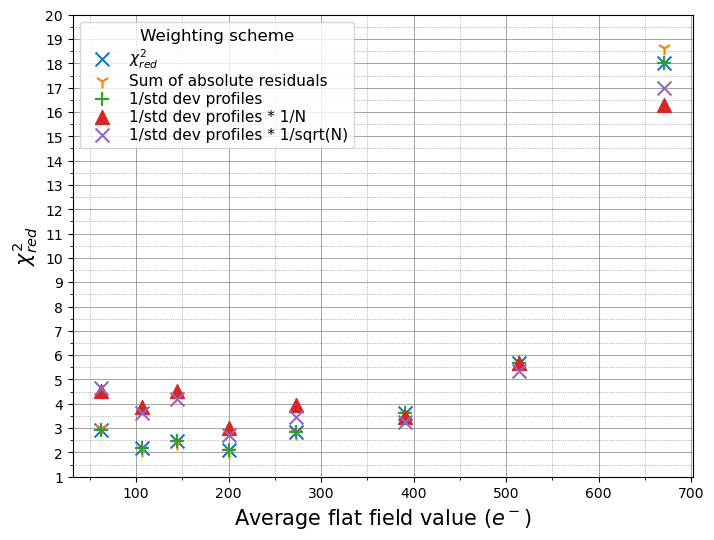

In [508]:
# i=2


plt.close()

scale_factor = 1
fig, ax = plt.subplots(1, 1, figsize=(scale_factor * 8, scale_factor * 6))
# y_major_locator = LogLocator(base=10.0, subs='auto', numticks=10)
# y_minor_locator = LogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100)
# x_major_locator = LogLocator(base=10.0, subs='auto', numticks=10)
# x_minor_locator = LogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100)
y_major_locator = MultipleLocator(1)
y_minor_locator = MultipleLocator(0.5)

x_major_locator = MultipleLocator(100)
x_minor_locator = MultipleLocator(50)
# y_major_locator = LogLocator(base=10.0, subs='auto', numticks=100)
# y_minor_locator = LogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100)

ax.xaxis.set_major_locator(x_major_locator)
ax.xaxis.set_minor_locator(x_minor_locator)

ax.yaxis.set_major_locator(y_major_locator)
ax.yaxis.set_minor_locator(y_minor_locator)

# ax.set_ylim(1,10)

ax.grid(which="major", linestyle="-", linewidth="0.5", color="gray")
ax.grid(which="minor", linestyle=":", linewidth="0.5", color="gray")
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_11[6],
    marker="x",
    label=r"$\chi^2_{red}$",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_11[7],
    marker="1",
    label=f"Sum of absolute residuals",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_11[6],
    marker="+",
    label=f"1/std dev profiles",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_11[8],
    marker="^",
    label=f"1/std dev profiles * 1/N",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_11[10],
    marker="x",
    label=f"1/std dev profiles * 1/sqrt(N)",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_5[5],
    marker="1",
    label=f"{legend_labels_4[5]}",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_5[6],
    marker="+",
    label=f"{legend_labels_4[6]}",
    zorder=10,
    s=100,
)
ax.scatter(
    avg_sig_vals,
    reduced_chi2_list_5[7],
    marker="^",
    label=f"{legend_labels_4[7]}",
    zorder=10,
    s=100,
)
# [2,8,14,19,22,25,27 - for 300 EPER tail


#     OU_filenames_11[4]
# OU_filenames_11[10]
# OU_filenames_11[16]
# OU_filenames_11[20]
# OU_filenames_11[23]
# OU_filenames_11[26]
# OU_filenames_11[28]
# OU_filenames_11[35]
# OU_filenames_11[38]

# ax.scatter(avg_sig_vals[:5],reduced_chi2_list_11[5][i][:5],marker='.',label=f'10',zorder=10)

# [0,6,12,18,21,24,29] - fule changign express full tail
# [2,8,14,19,22,25,27 - for 300 EPER tail
# [4,10,16,20,23,26,28] - for 50 EPER

# ax.scatter(avg_sig_vals_ESA[3:],Batch_5_id6_free_params_reduced_chi2_results[i][3:],marker='X',label='Best ESA calibration results',zorder=10)

ax.set_xlabel("Average flat field value ($e^-$)", fontsize=15)
ax.set_ylabel(r"$\chi^2_{red}$", fontsize=15)
# ax.yscale('log')
# ax.set_xlim(100,1000)
ax.set_ylim(1, 20)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.legend(
    title="Weighting scheme", loc=2, labelspacing=0.2, fontsize=11, title_fontsize=12
)
# ax.legend(title=f'Express : EPER',loc=1,fontsize=10,title_fontsize=11)
# ax.legend(title=f'{red_chi2_str} tail calculation length (pixels)',loc=1,fontsize=10,title_fontsize=11,labelspacing=0.2)
# plt.legend(title='EPER (pixels) : Express',loc=4)
plt.legend.align = "bottom right"
# plt.savefig(f'Graphs/reduced_chi2/23_05_2024/varying_exp_300_EPER_{reduced_chi2_tail_calc[i]}_tail_calc_1_to_100.png',dpi=150)
# plt.savefig(f'../latest_notebooks/Graphs/redone_for_thesis_12_6_24/reduced_chi2/weighting_function_e.png',dpi=150)
# plt.savefig(f'../latest_notebooks/Graphs/redone_for_thesis_12_6_24/reduced_chi2/fitness_function_function_e.png',dpi=150)